In [1]:
!git clone https://github.com/CVLAB-Unibo/ipcv-assignment-2.git

Cloning into 'ipcv-assignment-2'...
remote: Enumerating objects: 7371, done.
remote: Total 7371 (delta 0), reused 0 (delta 0), pack-reused 7371 (from 1)
Receiving objects: 100% (7371/7371), 753.77 MiB | 52.02 MiB/s, done.
Updating files: 100% (7396/7396), done.


In [2]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [3]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("ipcv-assignment-2") / "dataset"
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)

        return img, label
    
    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name), 
                labels.append(int(label) - 1)

        return names, labels

In [4]:
import torch
import torchvision
from torchvision import transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image
import random
from collections import Counter


In [5]:

#trasformazione in un tensore pytorch e creazione di tre diversi split
#train, validation, test e stampo cosi so quanti ne ha ciascuno
to_tensor = transforms.ToTensor()

train_ds = OxfordPetDataset(split="train", transform=to_tensor)
val_ds   = OxfordPetDataset(split="val", transform=to_tensor)
test_ds  = OxfordPetDataset(split="test", transform=to_tensor)

print("Size train:", len(train_ds))
print("Size val:  ", len(val_ds))
print("Size test: ", len(test_ds))
num_classes = train_ds.get_num_classes()
print("Num classes:", num_classes)


Size train: 3669
Size val:   1834
Size test:  1846
Num classes: 37


Label min(label, items_count), max(label, items_count): (0, 98), (36, 100). Num unique labels: 37


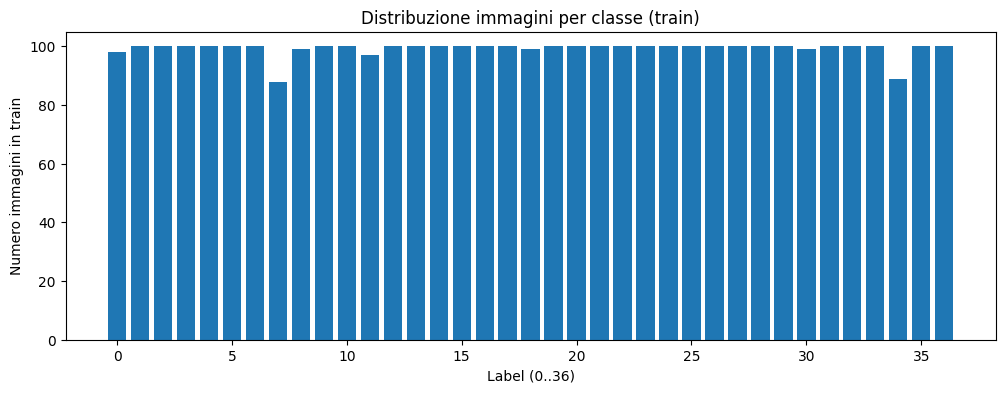

In [6]:
def class_counts(dataset):
    return Counter(dataset.labels)

counts = class_counts(train_ds)
labels_sorted = sorted(counts.items(), key=lambda x: x[0])
print(f"Label min(label, items_count), max(label, items_count): {min(labels_sorted)}, {max(labels_sorted)}. Num unique labels: {len(labels_sorted)}")

plt.figure(figsize=(12,4))
plt.bar([x[0] for x in labels_sorted], [x[1] for x in labels_sorted])
plt.xlabel("Label (0..36)")
plt.ylabel("Numero immagini in train")
plt.title("Distribuzione immagini per classe (train)")
plt.show()


adesso voglio capire dato che ho 3.6 k che non è enorme per una CNN come mettere le augmentation che sono importanti per evitare overfitting e per avere minor differenza di immagini per ogni classe posso usare i psi nella crossentrpyloss e/o un weight random sampler.

mantengo le dimensioni e voglio visualizzare delle immagini del dataset 

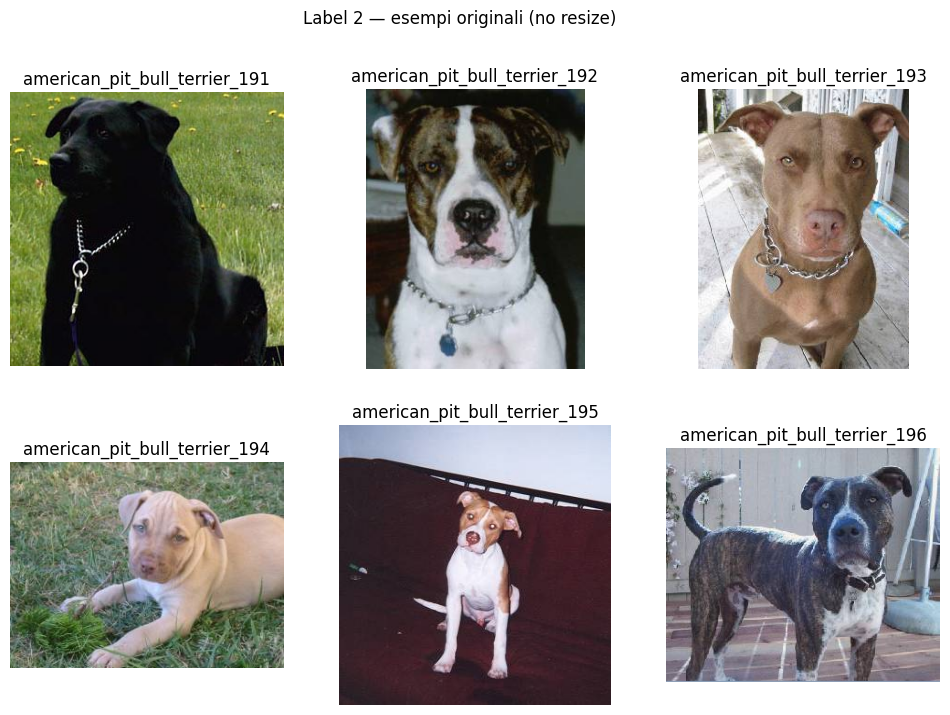

Label 0 (98 immagini): esempio nomi: ['Abyssinian_201', 'Abyssinian_202', 'Abyssinian_204']
Label 1 (100 immagini): esempio nomi: ['american_bulldog_203', 'american_bulldog_205', 'american_bulldog_207']
Label 2 (100 immagini): esempio nomi: ['american_pit_bull_terrier_191', 'american_pit_bull_terrier_192', 'american_pit_bull_terrier_193']
Label 3 (100 immagini): esempio nomi: ['basset_hound_191', 'basset_hound_192', 'basset_hound_193']
Label 4 (100 immagini): esempio nomi: ['beagle_195', 'beagle_196', 'beagle_197']


In [7]:
from collections import defaultdict
label_to_names = defaultdict(list)
for name, label in zip(train_ds.names, train_ds.labels):
    label_to_names[label].append(name)

def show_examples_for_label_original(label, n=6, figsize=(12,8)):
    names = label_to_names[label][:n]
    plt.figure(figsize=figsize)
    for i, nm in enumerate(names):
        img = Image.open(train_ds.root / "images" / f"{nm}.jpg").convert("RGB")
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f"{nm}")
        plt.axis('off')
    plt.suptitle(f"Label {label} — esempi originali (no resize)")
    plt.show()
    
show_examples_for_label_original(2, n=6)

#prime 3 immagini per ciascuna delle 5 classi per vedere esempio 
for lab in range(5):
    print(f"Label {lab} ({len(label_to_names[lab])} immagini): esempio nomi:", label_to_names[lab][:3])



distribuzione di immagini per classe nel train 

Ogni immagine è un tensore di forma (3, H, W) con valori in [0,1] perche transforms.ToTensor() ha trasformato in tensori.
La media che rappresenta la luminosità media di ciascun canale (R, G, B) su tutto il training set.
La deviazione standard invece rappresenta quanto variano i valori di ciascun canale (il contrasto medio).
voglio normalizzare i dati con x norm che sarebbe x meno la media diviso la deviazione standard per poter avere i canali centrati inotrno a 0 e con varianza 1 
per calcolarli prima di tutto devo ridimensionare le immagini tutte con la stessa dimensione altrimenti ho un errore


adesso con mean e std che ho ricavato posso definrie le trasformazioni per addestramento della rete 

Train:

- Resize(256) → RandomResizedCrop(224) per ridimensionare e variare la porzione visibile dell’immagine

- RandomHorizontalFlip() e ColorJitter() per aumentare la varietà (data augmentation)

- ToTensor() per convertire in tensore

- Normalize() per normalizzare 

Validation / Test:

- Niente augmentation

- Resize(256) → CenterCrop(224) per mantenere la porzione centrale

- ToTensor() e Normalize()

In [8]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torch

# Deterministic transform for stats: match final input size (use Resize+CenterCrop if training uses RandomResizedCrop)
stats_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# create temporary dataset/loader for stats (no augmentation)
ds_stats = OxfordPetDataset(split="train", transform=stats_transform)
loader_stats = DataLoader(ds_stats, batch_size=64, shuffle=False, num_workers=4)

sum_rgb = torch.zeros(3)
sum_sq_rgb = torch.zeros(3)
total_pixels = 0

for imgs, _ in loader_stats:
    # imgs: [B,3,H,W] in [0,1]
    B, C, H, W = imgs.shape
    imgs_flat = imgs.view(B, C, -1)                    # [B,3, H*W]
    sum_rgb += imgs_flat.sum(dim=(0,2))               # sum per channel
    sum_sq_rgb += (imgs_flat ** 2).sum(dim=(0,2))     # sum squares per channel
    total_pixels += B * H * W

mean = sum_rgb / total_pixels
var = sum_sq_rgb / total_pixels - mean ** 2
std = torch.sqrt(var)

mean_values = mean.tolist()
std_values  = std.tolist()

print("Computed mean:", mean_values)
print("Computed std: ", std_values)



Computed mean: [0.4908042252063751, 0.4524926245212555, 0.3973051905632019]
Computed std:  [0.2626195549964905, 0.2577695846557617, 0.26469138264656067]


In [11]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_values, std=std_values),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_values, std=std_values),
])

# ricrea dataset e loader UNA SOLA VOLTA qui
train_ds = OxfordPetDataset(split="train", transform=train_transform)
val_ds   = OxfordPetDataset(split="val", transform=val_transform)
test_ds  = OxfordPetDataset(split="test", transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=4)

print(f"Train shape : {len(train_ds)} and loader with {len(train_loader)} batches")
print(f"Train data example: {train_loader.dataset[0][0].shape}")  # should be [3,224,224]
print(f"Example of image and label: {train_loader}")

Train shape : 3669 and loader with 115 batches
Train data example: torch.Size([3, 224, 224])
Example of image and label: <torch.utils.data.dataloader.DataLoader object at 0x7e28e153b350>


In [12]:
# Batch di esempio dal train_loader
imgs, labels = next(iter(train_loader))
print(f"Batch shape: {imgs.shape}")
print(f"Labels shape: {labels.shape}")
print()

# Min/Max dopo normalizzazione (POSSONO essere negativi!)
print(f"Valori min (post-norm): {imgs.min().item():.4f}")
print(f"Valori max (post-norm): {imgs.max().item():.4f}")
print()

# Media e std per canale (dovrebbero essere vicini a 0 e 1)
batch_mean = imgs.mean(dim=[0,2,3])  # media per canale
batch_std = imgs.std(dim=[0,2,3])    # std per canale
print(f"Media per canale (dovrebbe ≈ 0): {batch_mean.tolist()}")
print(f"Std per canale (dovrebbe ≈ 1):   {batch_std.tolist()}")
print()

# CONTROLLO: Denormalizziamo un'immagine per vedere se torna in [0,1]
mean_t = torch.tensor(mean_values).view(1, 3, 1, 1)
std_t = torch.tensor(std_values).view(1, 3, 1, 1)
img_denorm = imgs[:1] * std_t + mean_t  # applica inverso della normalizzazione
print(f"Immagine denormalizzata - min (dovrebbe ≈ [0, 1]): {img_denorm.min().item():.4f}, max: {img_denorm.max().item():.4f}")

Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])

Valori min (post-norm): -1.8689
Valori max (post-norm): 2.2770

Media per canale (dovrebbe ≈ 0): [-0.2891641855239868, -0.23221373558044434, -0.1671684831380844]
Std per canale (dovrebbe ≈ 1):   [1.1000304222106934, 1.0451245307922363, 1.0190349817276]

Immagine denormalizzata - min (dovrebbe ≈ [0, 1]): 0.0000, max: 0.9804


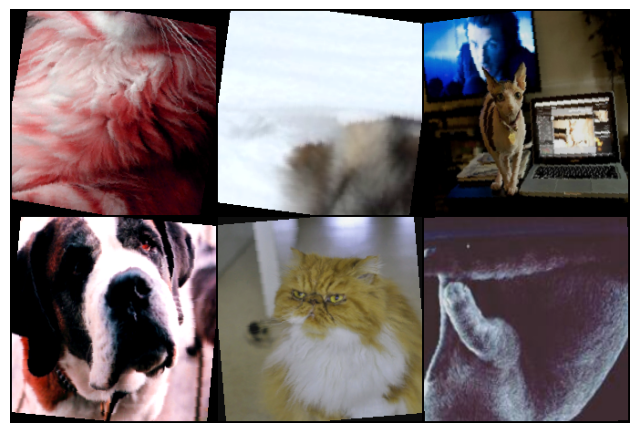

In [13]:

def show_batch(imgs, mean, std, n=6):
    mean = torch.tensor(mean).view(3,1,1)
    std = torch.tensor(std).view(3,1,1)
    imgs = imgs[:n] * std + mean  # denormalizza
    imgs = torch.clamp(imgs, 0, 1)
    grid = transforms.ToPILImage()(torchvision.utils.make_grid(imgs, nrow=3))
    plt.figure(figsize=(8,6))
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

show_batch(imgs, mean_values, std_values, n=6)


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [15]:

class PetNet(nn.Module):
    def __init__(self, num_classes=37):
        super().__init__()
        # --- Feature extractor ---
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # -> 32 x 112 x 112
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # -> 64 x 56 x 56
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # -> 128 x 28 x 28
        )

        # --- Classifier ---
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # -> 128 x 1 x 1
        self.fc1 = nn.Linear(128, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.global_pool(x)        # <<< apply adaptive pooling
        x = torch.flatten(x, 1)       # B x 128
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
model = PetNet(num_classes=num_classes)
print("PetNet instantiated. Params: {:.2f}M".format(sum(p.numel() for p in model.parameters())/1e6))


PetNet instantiated. Params: 0.14M


In [16]:

# ConvNeXt implementation (tiny/small variants) following the paper structure.
# Uses existing torch / nn in the notebook; instantiate with num_classes available above.

class LayerNorm2d(nn.Module):
    """LayerNorm for channels-first tensors (B,C,H,W) implemented via nn.LayerNorm over last dim."""
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.norm = nn.LayerNorm(dim, eps=eps)

    def forward(self, x):
        # x: B,C,H,W -> B,H,W,C -> LayerNorm over C -> back
        x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        return x.permute(0, 3, 1, 2)


class ConvNeXtBlock(nn.Module):
    """Single ConvNeXt block: depthwise conv -> LayerNorm (channels-last) -> MLP (FFN) -> residual."""
    def __init__(self, dim, mlp_ratio=4.0, drop_path=0.0, layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)  # depthwise conv
        self.norm = LayerNorm2d(dim)
        hidden_dim = int(dim * mlp_ratio)
        # pointwise MLP implemented with nn.Linear applied on channels-last
        self.pw = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )
        if layer_scale_init_value > 0:
            self.gamma = nn.Parameter(layer_scale_init_value * torch.ones(dim), requires_grad=True)
        else:
            self.gamma = None

    def forward(self, x):
        shortcut = x
        x = self.dwconv(x)
        x = self.norm(x)                # stays (B,C,H,W)
        x = x.permute(0, 2, 3, 1)       # -> (B,H,W,C) for Linear
        x = self.pw(x)
        x = x.permute(0, 3, 1, 2)       # -> (B,C,H,W)
        if self.gamma is not None:
            x = self.gamma.view(1, -1, 1, 1) * x
        return shortcut + x


class ConvNeXt(nn.Module):
    """
    ConvNeXt backbone + classification head.
    depths: list with number of blocks per stage (4 stages).
    dims: list with channel dims per stage.
    """
    def __init__(self, in_chans=3, num_classes=1000, depths=(3,3,9,3), dims=(96,192,384,768),
                 layer_scale_init_value=1e-6):
        super().__init__()

        assert len(depths) == 4 and len(dims) == 4

        # stem / patchify
        self.downsample_layers = nn.ModuleList()
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),  # 224 -> 56
            LayerNorm2d(dims[0])
        )
        self.downsample_layers.append(stem)

        # stages and downsample between stages
        self.stages = nn.ModuleList()
        for i in range(4):
            # build blocks for this stage
            blocks = [ConvNeXtBlock(dims[i], layer_scale_init_value=layer_scale_init_value) for _ in range(depths[i])]
            self.stages.append(nn.Sequential(*blocks))

            if i < 3:
                # downsample to next stage (patchify)
                down = nn.Sequential(
                    LayerNorm2d(dims[i]),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2)  # halves spatial dims
                )
                self.downsample_layers.append(down)

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6)  # final LayerNorm (channels-last)
        self.head = nn.Linear(dims[-1], num_classes)

        # init weights similar to paper (simple)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # x: B,C,H,W
        for i, stage in enumerate(self.stages):
            x = self.downsample_layers[i](x) if i < len(self.downsample_layers) else x
            x = stage(x)

        # global pooling + head
        # convert to channels-last for LayerNorm
        x = x.permute(0, 2, 3, 1)         # B,H,W,C
        x = self.norm(x)
        x = x.mean(dim=(1, 2))            # global average pooling -> B,C
        x = self.head(x)
        return x


# Helper constructors for common sizes
def convnext_tiny(num_classes=num_classes):
    return ConvNeXt(num_classes=num_classes, depths=(3,3,9,3), dims=(96,192,384,768))

def convnext_small(num_classes=num_classes):
    return ConvNeXt(num_classes=num_classes, depths=(3,3,27,3), dims=(96,192,384,768))


# Instantiate a ConvNeXt tiny model for this task
convnext = convnext_tiny(num_classes=num_classes)
print("ConvNeXt (tiny) instantiated. Params: {:.2f}M".format(sum(p.numel() for p in convnext.parameters())/1e6))

ConvNeXt (tiny) instantiated. Params: 27.85M


In [17]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
print("Device:", device)

modelPet = PetNet(num_classes=37).to(device)
optimizer_pet = optim.Adam(modelPet.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_pet = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_pet, mode='min', patience=3, factor=0.5)

modelConvNext = convnext.to(device)
optimizer_convnext = optim.Adam(modelConvNext.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_conv = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_convnext, mode='min', patience=3, factor=0.5)



Device: cuda


In [22]:

def train_one_epoch(model, dataloader, optimizer, criterion, device, debug=False):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # sanity check: optimizer must include some parameters of this model
    opt_param_ids = {id(p) for g in optimizer.param_groups for p in g['params']}
    model_param_ids = {id(p) for p in model.parameters()}
    if opt_param_ids.isdisjoint(model_param_ids):
        print("WARNING: optimizer does not contain parameters of the provided model -> weights won't update")

    # snapshot first parameter to check update
    first_before = None
    for p in model.parameters():
        first_before = p.detach().cpu().clone()
        break

    for batch_idx, (imgs, labels) in enumerate(dataloader):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()

        # diagnostic: compute grad norm
        total_grad_norm = 0.0
        for p in model.parameters():
            if p.grad is not None:
                total_grad_norm += p.grad.data.norm(2).item() ** 2
        total_grad_norm = total_grad_norm ** 0.5

        if debug and (batch_idx % 50 == 0):
            print(f"batch {batch_idx}: loss={loss.item():.4f}, grad_norm={total_grad_norm:.6f}")

        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    # check parameter change
    first_after = None
    for p in model.parameters():
        first_after = p.detach().cpu().clone()
        break
    if first_before is not None and first_after is not None:
        diff = (first_after - first_before).abs().sum().item()
        if diff == 0:
            print("WARNING: first parameter did NOT change during the epoch -> check optimizer / zero_grad / lr / frozen params")

    return running_loss / total, correct / total


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()

    return running_loss / total, correct / total

In [25]:
def get_preds_and_labels(model, loader, device):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            out = model(imgs)
            preds.append(out.argmax(1).cpu())
            trues.append(labels)
    preds = torch.cat(preds).numpy()
    trues = torch.cat(trues).numpy()
    return preds, trues

num_epochs = 0
# training sicuro per PetNet
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(modelPet, train_loader, optimizer_pet, criterion, device, debug=False)
    val_loss, val_acc = evaluate(modelPet, val_loader, criterion, device)
    scheduler_pet.step(val_loss)
    print(f"PetNet Epoch {epoch+1}/{num_epochs} | train_loss={train_loss:.4f} train_acc={train_acc:.4f} | val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

num_epochs = 100
# training sicuro per ConvNeXt
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(modelConvNext, train_loader, optimizer_convnext, criterion, device, debug=False)
    val_loss, val_acc = evaluate(modelConvNext, val_loader, criterion, device)
    scheduler_conv.step(val_loss)
    print(f"ConvNeXt Epoch {epoch+1}/{num_epochs} | train_loss={train_loss:.4f} train_acc={train_acc:.4f} | val_loss={val_loss:.4f} val_acc={val_acc:.4f}")


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e28ef0323e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e28ef0323e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

ConvNeXt Epoch 1/100 | train_loss=3.5779 train_acc=0.0431 | val_loss=3.5455 val_acc=0.0496


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e28ef0323e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e28ef0323e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

ConvNeXt Epoch 2/100 | train_loss=3.5731 train_acc=0.0436 | val_loss=3.5491 val_acc=0.0442


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e28ef0323e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e28ef0323e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

ConvNeXt Epoch 3/100 | train_loss=3.5506 train_acc=0.0442 | val_loss=3.5813 val_acc=0.0414


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e28ef0323e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e28ef0323e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

ConvNeXt Epoch 4/100 | train_loss=3.5504 train_acc=0.0515 | val_loss=3.5391 val_acc=0.0496


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e28ef0323e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e28ef0323e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

ConvNeXt Epoch 5/100 | train_loss=3.5385 train_acc=0.0496 | val_loss=3.5286 val_acc=0.0496


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e28ef0323e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e28ef0323e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

ConvNeXt Epoch 6/100 | train_loss=3.5333 train_acc=0.0515 | val_loss=3.5582 val_acc=0.0420


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e28ef0323e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e28ef0323e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

ConvNeXt Epoch 7/100 | train_loss=3.5304 train_acc=0.0504 | val_loss=3.5258 val_acc=0.0502


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e28ef0323e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e28ef0323e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

ConvNeXt Epoch 8/100 | train_loss=3.5092 train_acc=0.0556 | val_loss=3.5042 val_acc=0.0600


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e28ef0323e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e28ef0323e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

ConvNeXt Epoch 9/100 | train_loss=3.5173 train_acc=0.0600 | val_loss=3.5005 val_acc=0.0567
ConvNeXt Epoch 10/100 | train_loss=3.4952 train_acc=0.0646 | val_loss=3.4830 val_acc=0.0502
ConvNeXt Epoch 11/100 | train_loss=3.4968 train_acc=0.0518 | val_loss=3.5108 val_acc=0.0562
ConvNeXt Epoch 12/100 | train_loss=3.5004 train_acc=0.0600 | val_loss=3.4973 val_acc=0.0540
ConvNeXt Epoch 13/100 | train_loss=3.5070 train_acc=0.0553 | val_loss=3.4716 val_acc=0.0660
ConvNeXt Epoch 14/100 | train_loss=3.4888 train_acc=0.0534 | val_loss=3.4743 val_acc=0.0578
ConvNeXt Epoch 15/100 | train_loss=3.4882 train_acc=0.0660 | val_loss=3.4779 val_acc=0.0583
ConvNeXt Epoch 16/100 | train_loss=3.4707 train_acc=0.0600 | val_loss=3.4977 val_acc=0.0562
ConvNeXt Epoch 17/100 | train_loss=3.4877 train_acc=0.0608 | val_loss=3.5033 val_acc=0.0611
ConvNeXt Epoch 18/100 | train_loss=3.4726 train_acc=0.0613 | val_loss=3.4630 val_acc=0.0687
ConvNeXt Epoch 19/100 | train_loss=3.4577 train_acc=0.0657 | val_loss=3.4818 val_

KeyboardInterrupt: 

In [ ]:
for model in [modelPet, modelConvNext]:
    preds, trues = get_preds_and_labels(model, val_loader, device)
    acc = skm.accuracy_score(trues, preds)
    macro_f1 = skm.f1_score(trues, preds, average='macro')
    cm = skm.confusion_matrix(trues, preds)
    print(f"Validation results for {model.__class__.__name__}: accuracy={acc:.4f}, macro-F1={macro_f1:.4f}")
    print("Confusion matrix (shape):", cm.shape)


Validation results for PetNet: accuracy=0.0491, macro-F1=0.0168
Confusion matrix (shape): (37, 37)
Validation results for ConvNeXt: accuracy=0.0431, macro-F1=0.0231
Confusion matrix (shape): (37, 37)


In [ ]:
# ...existing code...
import torch, numpy as np, random
from collections import Counter

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", device)

# 1) dataset / loader checks
print("Train/Val/Test sizes:", len(train_ds), len(val_ds), len(test_ds))
counts = Counter(train_ds.labels)
print("Label range:", min(counts), "->", max(counts), " #classes:", train_ds.get_num_classes())
print("Some class counts (first 10):", list(counts.items())[:10])

# 2) batch sanity
imgs, labels = next(iter(train_loader))
print("Batch shapes imgs, labels:", imgs.shape, labels.shape)
print("Batch min/max (post-normalize):", imgs.min().item(), imgs.max().item())
print("Per-channel mean/std (batch):", imgs.mean(dim=[0,2,3]).tolist(), imgs.std(dim=[0,2,3]).tolist())

# 3) forward/backward/update check for both models
def quick_update_check(model, optimizer=None, name="model"):
    model = model.to(device)
    model.train()
    imgs_b, labels_b = imgs.to(device), labels.to(device)
    # snapshot first param
    p0 = None
    for p in model.parameters():
        p0 = p.detach().cpu().clone()
        break
    # fallback optimizer if not provided
    if optimizer is None:
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    optimizer.zero_grad()
    out = model(imgs_b)
    print(f"{name} output shape:", out.shape)
    loss = criterion(out, labels_b)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
    optimizer.step()
    # check param changed
    p1 = None
    for p in model.parameters():
        p1 = p.detach().cpu().clone()
        break
    changed = False
    if p0 is not None and p1 is not None:
        changed = ((p1 - p0).abs().sum().item() > 0)
    print(f"{name} loss: {loss.item():.4f}, first-param-changed: {changed}")
    return changed

# try using named optimizers if present
opt_pet = globals().get("optimizer_pet", None)
opt_conv = globals().get("optimizer_convnext", None)

ok_pet = quick_update_check(modelPet, opt_pet, "PetNet")
ok_conv = quick_update_check(modelConvNext, opt_conv, "ConvNeXt")

# 4) evaluate() usage test (no debug arg)
val_loss, val_acc = evaluate(modelConvNext, val_loader, criterion, device)
print("Eval ConvNeXt val_loss, val_acc:", val_loss, val_acc)

# 5) quick prediction statistics on small subset
modelConvNext.eval()
with torch.no_grad():
    imgs_s, labels_s = next(iter(val_loader))
    preds = modelConvNext(imgs_s.to(device)).argmax(1).cpu().numpy()
    print("Sample preds/labels (first 8):", preds[:8], labels_s.numpy()[:8])

# Summary
if not ok_pet: print("WARNING: PetNet params did NOT update -> check optimizer_pet or frozen params")
if not ok_conv: print("WARNING: ConvNeXt params did NOT update -> check optimizer_convnext or frozen params")
print("If you saw a TypeError earlier about evaluate(debug=...), remove the 'debug' arg when calling evaluate().")
# ...existing code...

DEVICE: cuda
Train/Val/Test sizes: 3669 1834 1846
Label range: 0 -> 36  #classes: 37
Some class counts (first 10): [(0, 98), (1, 100), (2, 100), (3, 100), (4, 100), (5, 100), (6, 100), (7, 88), (8, 99), (9, 100)]
Batch shapes imgs, labels: torch.Size([32, 3, 224, 224]) torch.Size([32])
Batch min/max (post-normalize): -2.1419098377227783 2.6753764152526855
Per-channel mean/std (batch): [-0.2992740273475647, -0.2804846167564392, -0.33242788910865784] [1.0832358598709106, 1.1167192459106445, 1.0523169040679932]
PetNet output shape: torch.Size([32, 37])
PetNet loss: 3.4656, first-param-changed: True
ConvNeXt output shape: torch.Size([32, 37])
ConvNeXt loss: 3.5069, first-param-changed: True
Eval ConvNeXt val_loss, val_acc: 3.5595428215638374 0.05561613958560523
Sample preds/labels (first 8): [ 0  3  3  0  5  0  5 19] [0 0 0 0 0 0 0 0]
If you saw a TypeError earlier about evaluate(debug=...), remove the 'debug' arg when calling evaluate().


Img tensor stats: -0.7622231245040894 1.101258397102356


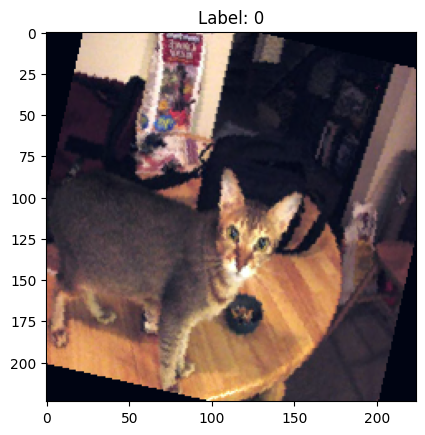

In [ ]:
import matplotlib.pyplot as plt
img, label = train_dataset[0]
print("Img tensor stats:", img.mean().item(), img.std().item())
plt.imshow(img.permute(1, 2, 0).cpu() * 0.229 + 0.485)  # denormalizza
plt.title(f"Label: {label}")
plt.show()


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from pathlib import Path
from PIL import Image


In [ ]:
import torch.nn as nn
import torch

class DeepCNN(nn.Module):
    def __init__(self, num_classes, use_batchnorm=False, use_dropout=True):
        super().__init__()
        layers = []
        in_channels = 3
        channels_list = [32, 64, 128, 256]

        for out_channels in channels_list:
            layers.append(nn.Conv2d(in_channels, out_channels, 3, padding=1))
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2))
            in_channels = out_channels
        
        self.features = nn.Sequential(*layers)
        
        final_size = 224
        for _ in channels_list:
            final_size //= 2  # 5 pool 2x2 → 224 → 112 → 56 → 28 → 14 → 7
        
        classifier_layers = [
            nn.Flatten(),
            nn.Linear(in_channels * final_size * final_size, 512),
            nn.ReLU()
        ]
        if use_dropout:
            classifier_layers.append(nn.Dropout(0.5))
        classifier_layers.append(nn.Linear(512, num_classes))
        self.classifier = nn.Sequential(*classifier_layers)
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

num_classes = train_dataset.get_num_classes()
model = DeepCNN(num_classes=num_classes)


In [ ]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(init_weights)





device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


DeepCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50176, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=37, bias=True)
  )
)

In [ ]:
imgs, _ = next(iter(train_loader))
imgs = imgs.to(device)
with torch.no_grad():
    out = model.features(imgs)
print("Mean:", out.mean().item(), "Std:", out.std().item())


Mean: 1.3503831624984741 Std: 1.7227643728256226


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)


In [ ]:
subset = torch.utils.data.Subset(train_dataset, range(200))
small_loader = DataLoader(subset, batch_size=8, shuffle=True)

for epoch in range(10):
    model.train()
    loss_sum = 0
    for imgs, labels in small_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()
        loss_sum += loss.item()
    print(f"Epoch {epoch+1}, Loss: {loss_sum/len(small_loader):.4f}")


Epoch 1, Loss: 2.5307
Epoch 2, Loss: 1.3092
Epoch 3, Loss: 0.8480
Epoch 4, Loss: 1.1663
Epoch 5, Loss: 0.8680
Epoch 6, Loss: 0.8614
Epoch 7, Loss: 0.6939
Epoch 8, Loss: 0.7064
Epoch 9, Loss: 0.5132
Epoch 10, Loss: 0.6400


In [ ]:
model = DeepCNN(num_classes, use_batchnorm=False).to(device)
model.apply(init_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)


In [ ]:
imgs, labels = next(iter(train_loader))
imgs, labels = imgs.to(device), labels.to(device)
outputs = model(imgs)
print("Output shape:", outputs.shape)
print("Output mean:", outputs.mean().item(), "std:", outputs.std().item())
print("Label min/max:", labels.min().item(), labels.max().item())


Output shape: torch.Size([64, 37])
Output mean: 0.5239895582199097 std: 4.433313846588135
Label min/max: 0 36


In [ ]:
# 🔧 Parametri aggiornati
num_epochs = 15
train_losses = []
val_accuracies = []

# 1️⃣ Ottimizzatore + scheduler più stabili
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# 2️⃣ Ciclo di training
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping per stabilità
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()
        
        running_loss += loss.item()
    
    # 3️⃣ Media loss per epoca
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # 4️⃣ Validazione
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    val_acc = correct / total
    val_accuracies.append(val_acc)
    
    # 5️⃣ Scheduler
    scheduler.step(avg_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Val Accuracy: {val_acc:.4f}")


Epoch 1/15, Loss: 4.2845, Val Accuracy: 0.0344
Epoch 2/15, Loss: 3.6090, Val Accuracy: 0.0393
Epoch 3/15, Loss: 3.6024, Val Accuracy: 0.0436
Epoch 4/15, Loss: 3.5881, Val Accuracy: 0.0474
Epoch 5/15, Loss: 3.5830, Val Accuracy: 0.0420


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
class AblationCNN(nn.Module):
    def __init__(self, num_classes, depth=5, use_batchnorm=True, use_dropout=True):
        super().__init__()
        layers = []
        in_channels = 3
        channels_list = [32, 64, 128, 256, 512]  # massimo 5 blocchi

        for i in range(depth):
            out_channels = channels_list[i]
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2))
            in_channels = out_channels
        
        self.features = nn.Sequential(*layers)
        
        # calcoliamo la dimensione del feature map finale
        final_size = 224
        for _ in range(depth):
            final_size //= 2
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_channels * final_size * final_size, 512),
            nn.ReLU(),
        )
        if use_dropout:
            self.classifier.add_module("dropout", nn.Dropout(0.5))
        self.classifier.add_module("output", nn.Linear(512, num_classes))
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [ ]:
configs = [
    {"name": "Full Model", "depth":5, "use_batchnorm":True, "use_dropout":True},
    {"name": "No Dropout", "depth":5, "use_batchnorm":True, "use_dropout":False},
    {"name": "No BatchNorm", "depth":5, "use_batchnorm":False, "use_dropout":True},
    {"name": "Shallow 3 layers", "depth":3, "use_batchnorm":True, "use_dropout":True},
    {"name": "No Augmentation", "depth":5, "use_batchnorm":True, "use_dropout":True, "augment":False}
]


In [ ]:
def train_model(config, train_loader, val_loader, num_classes, device, epochs=10):
    model = AblationCNN(num_classes=num_classes,
                        depth=config.get("depth",5),
                        use_batchnorm=config.get("use_batchnorm",True),
                        use_dropout=config.get("use_dropout",True))
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"{config['name']} - Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")
    
    acc = evaluate(model, val_loader)
    print(f"{config['name']} - Validation Accuracy: {acc:.4f}")
    return acc


In [ ]:
results = {}
for cfg in configs:
    acc = train_model(cfg, train_loader, val_loader, num_classes, device, epochs=10)
    results[cfg['name']] = acc

# Mostrare i risultati in tabella
import pandas as pd
df = pd.DataFrame(list(results.items()), columns=["Model Variant", "Validation Accuracy"])
print(df)


In [ ]:
import matplotlib.pyplot as plt

# Esempio: df contiene già i risultati della validation accuracy
# df = pd.DataFrame(list(results.items()), columns=["Model Variant", "Validation Accuracy"])

plt.figure(figsize=(10,6))
plt.bar(df["Model Variant"], df["Validation Accuracy"], color='skyblue')
plt.ylim(0, 1)
plt.ylabel("Validation Accuracy")
plt.title("Ablation Study - Effect of Model Components")
plt.xticks(rotation=45, ha='right')

# Aggiungiamo le etichette sopra ogni barra
for i, v in enumerate(df["Validation Accuracy"]):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
def train_model_tracking(config, train_loader, val_loader, num_classes, device, epochs=10):
    model = AblationCNN(num_classes=num_classes,
                        depth=config.get("depth",5),
                        use_batchnorm=config.get("use_batchnorm",True),
                        use_dropout=config.get("use_dropout",True))
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"{config['name']} - Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    val_acc = evaluate(model, val_loader)
    print(f"{config['name']} - Validation Accuracy: {val_acc:.4f}")
    
    return train_losses, val_acc


In [ ]:
history = {}

for cfg in configs:
    losses, acc = train_model_tracking(cfg, train_loader, val_loader, num_classes, device, epochs=10)
    history[cfg['name']] = {"train_loss": losses, "val_acc": acc}


In [ ]:
plt.figure(figsize=(12,6))

# Plot training loss per variante
for name, data in history.items():
    plt.plot(data["train_loss"], label=f"{name} - Loss")
    
# Plot validation accuracy come punti finali
for i, (name, data) in enumerate(history.items()):
    plt.scatter(len(data["train_loss"])-1, data["val_acc"], label=f"{name} - Val Acc", s=100)

plt.xlabel("Epoch")
plt.ylabel("Loss / Validation Accuracy")
plt.title("Training Loss and Validation Accuracy per Model Variant")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
